# ResNet-50

In [1]:
import os
import cv2
import pydicom
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import keras.applications as tfa

Using TensorFlow backend.


# Load and Transform Data

In [2]:
train = pd.read_csv('D:/CSE499/osic-pulmonary-fibrosis-progression/train.csv') 

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
def get_tab(df):
    " raturn an array which contains each patient normalized age, sex and smoking status"
    vector = [(df.Age.values[0] - 49) / (88 - 49)] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [5]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())): # i index, p patient id
    sub = train.loc[train.Patient == p, :] # find all data (weeks, FVC, Percent, Age, Sex, SmokingStatus) of a unique patient
    fvc = sub.FVC.values # fvc values of the patient during the follow-up
    weeks = sub.Weeks.values # follow-up weeks
    c = np.vstack([weeks, np.ones(len(weeks))]).T # create an array by the follow-up weeks of shape(len(weeks),2)
    a, b = np.linalg.lstsq(c, fvc)[0] # least-square sol, a=gradient matrix, b=right hand matrix 
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

C:\Users\Monir\anaconda3\envs\rabbi36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [6]:
def get_img(path):
    " read DICOM dataset and return resize images of size (512,512,1)"
    d = pydicom.dcmread(path) # read and parse the CT scan images (in DICOM format)
    resized_image = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512,512))
    return resized_image

In [7]:
from keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size):
        "key=patient, a=gradient matrix, tab=a particular patient's data"
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chooses n=batch_size number of patients
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0] # chooses some randomly images for kth patient
                img = get_img(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{k}/{i}') # resizes ith image of kth patient
                x.append(img) # append kth patient's image data in the list x
                a.append(self.a[k]) # append kth patient's gradinet in the list a
                tab.append(self.tab[k]) # append kth patient's tabular data in the tab list
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab) # convert list to array
        x = np.expand_dims(x, axis=-1) 
        return [x, tab] , a

# Build the Model

In [8]:
from keras.applications import resnet50, vgg16
from keras import Model
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, 
    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate 
)

In [9]:
def get_model(model, shape):
    models_dict = {
        'RNet50': resnet50.ResNet50(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_model(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,)) # indicates that the expected input will be batches of 4-dimensional vectors
    x2 = GaussianNoise(0.3)(inp2) # to mitigate overfitting
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [10]:
MODEL_CLASS = 'RNet50'
base_model = build_model(shape=(512, 512, 1), model_class=MODEL_CLASS)
base_model.summary()

C:\Users\Monir\anaconda3\envs\rabbi36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 16, 16, 2048) 23581440    input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet50[1][0]                   
____________________________________________________________________________________________

# Compile and Train the Model

In [11]:
BATCH_SIZE = 2
EPOCHS = 80
LR = 0.001
SAVE_BEST = True

In [12]:
import keras
P = np.array(P)
subs = []
folds_history = []

# """
# er = keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3,patience=15,verbose=1,mode="auto",baseline=None,
#       restore_best_weights=True,) #Stop training when a monitored metric has stopped improving.
# """

cpt = keras.callbacks.ModelCheckpoint(filepath=f'C:/Users/Monir/Documents/CSE499/models/ResNet/{MODEL_CLASS}_{EPOCHS}_epochs.h5',monitor='val_loss',verbose=1, 
    save_best_only=SAVE_BEST,mode='auto') #to save model or weights in a checkpoint file at lowest validation loss

rlp = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5, verbose=1, min_lr=1e-8) 
     #Reduce learning rate when a metric has stopped improving.
     # if improvement stops, after 5 epochs learning rate will be reduced

model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE),
                    validation_steps = 32,
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training Complete!!!')

C:\Users\Monir\anaconda3\envs\rabbi36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/80
32/32 [==============================] - 33s 1s/step - loss: 5.8915 - val_loss: 12608840.0000

Epoch 00001: val_loss improved from inf to 12608840.00000, saving model to C:/Users/Monir/Documents/CSE499/models/ResNet/RNet50_80_epochs.h5
Epoch 2/80
32/32 [==============================] - 7s 225ms/step - loss: 4.9283 - val_loss: 17997.2188

Epoch 00002: val_loss improved from 12608840.00000 to 17997.21875, saving model to C:/Users/Monir/Documents/CSE499/models/ResNet/RNet50_80_epochs.h5
Epoch 3/80
32/32 [==============================] - 7s 227ms/step - loss: 5.2760 - val_loss: 1037.2786

Epoch 00003: val_loss improved from 17997.21875 to 1037.27856, saving model to C:/Users/Monir/Documents/CSE499/models/ResNet/RNet50_80_epochs.h5
Epoch 4/80
32/32 [==============================] - 7s 226ms/step - loss: 4.7620 - val_loss: 409.0499

Epoch 00004: val_loss improved from 1037.27856 to 409.04993, saving model to C:/Users/Monir/Documents/CSE499/models/ResNet/RNet50_80_epochs.h5
Epoc

32/32 [==============================] - 7s 226ms/step - loss: 4.6286 - val_loss: 2.3380

Epoch 00046: val_loss did not improve from 0.40052
Epoch 47/80
32/32 [==============================] - 7s 226ms/step - loss: 4.3306 - val_loss: 4.6093

Epoch 00047: val_loss did not improve from 0.40052

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 48/80
32/32 [==============================] - 7s 226ms/step - loss: 4.6839 - val_loss: 0.9473

Epoch 00048: val_loss did not improve from 0.40052
Epoch 49/80
32/32 [==============================] - 7s 227ms/step - loss: 3.6484 - val_loss: 1.6097

Epoch 00049: val_loss did not improve from 0.40052
Epoch 50/80
32/32 [==============================] - 7s 226ms/step - loss: 4.2140 - val_loss: 4.4930

Epoch 00050: val_loss did not improve from 0.40052
Epoch 51/80
32/32 [==============================] - 7s 228ms/step - loss: 3.8272 - val_loss: 1.9444

Epoch 00051: val_loss did not improve from 0.40052
Epoch 52/80


# Save Model History

In [18]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'ResNet50_history_80_epoch.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'ResNet50_history_80_epoch.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Visualize Training Results 

In [19]:
result_dir = 'C:/Users/Monir/Documents/CSE499/results_and_figures/ResNet/'

import tikzplotlib
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

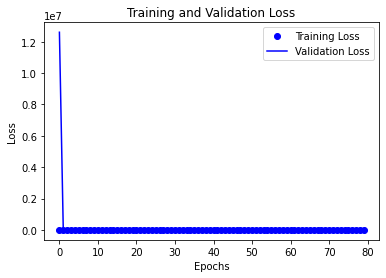

In [20]:
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.savefig(result_dir + 'ResNet80_loss_80_epoch.png')
plt.savefig(result_dir + 'ResNet80_loss_80_epoch.pdf', dpi=150)
tikzplotlib.save(result_dir + 'ResNet80_loss_80_epoch.tex', encoding='utf-8')

plt.show()

In [23]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

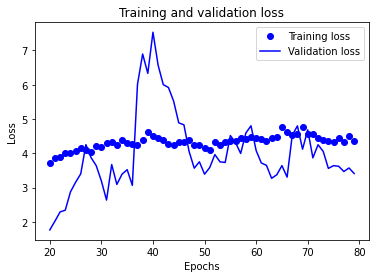

In [24]:
epochs_range = range(20,EPOCHS)
plt.plot(epochs_range,
         smooth_curve(loss[20:]), 'bo', label='Training loss')
plt.plot(epochs_range,smooth_curve(val_loss[20:]), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(result_dir + 'ResNet80_loss_smooth_80_epoch.png')
plt.savefig(result_dir + 'ResNet80_loss_smooth_80_epoch.pdf', dpi=150)
tikzplotlib.save(result_dir + 'ResNet80_loss_smooth_80_epoch.tex', encoding='utf-8')

plt.show()